In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from  matplotlib import font_manager, rc
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
import random
# model을 import
from models.model import Informer
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

In [29]:
font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
person_info = pd.read_csv("../dataset/LPOINT_BIG_COMP_01_DEMO.csv", low_memory = False)
purchase_info = pd.read_csv("../dataset/LPOINT_BIG_COMP_02_PDDE.csv", low_memory = False)

In [30]:
purchase_info.loc[purchase_info['de_hr'] == 0, 'de_hr'] = '00'
purchase_info.loc[purchase_info['de_hr'] == 1, 'de_hr'] = '01'
purchase_info.loc[purchase_info['de_hr'] == 2, 'de_hr'] = '02'
purchase_info.loc[purchase_info['de_hr'] == 3, 'de_hr'] = '03'
purchase_info.loc[purchase_info['de_hr'] == 4, 'de_hr'] = '04'
purchase_info.loc[purchase_info['de_hr'] == 5, 'de_hr'] = '05'
purchase_info.loc[purchase_info['de_hr'] == 6, 'de_hr'] = '06'
purchase_info.loc[purchase_info['de_hr'] == 7, 'de_hr'] = '07'
purchase_info.loc[purchase_info['de_hr'] == 8, 'de_hr'] = '08'
purchase_info.loc[purchase_info['de_hr'] == 9, 'de_hr'] = '09'

In [31]:
purchase_info['de_dt'] = purchase_info['de_dt'].astype('str')
purchase_info['de_hr'] = purchase_info['de_hr'].astype('str')
purchase_info['time'] = purchase_info['de_dt'] + purchase_info['de_hr']

In [32]:
purchase_info['time'] = pd.to_datetime(purchase_info['time'].str.slice(start=0, stop=4) + "/" + purchase_info['time'].str.slice(start=4, stop=6) + "/" +purchase_info['time'].str.slice(start=6, stop=8) + "/" + purchase_info['time'].str.slice(start=8, stop=10) + ":0")

In [33]:
# person_info에 ma_fem_dv가 남성인 것만 추출
man_values = person_info.loc[person_info['ma_fem_dv'] == '남성']['cust'].values
man_purchase = purchase_info[purchase_info['cust'].isin(man_values)]

In [34]:
annual_purchase = man_purchase[['time','buy_ct']].groupby('time').sum()
annual_purchase.reset_index(inplace=True)
annual_purchase

,time,buy_ct
0,2021-01-01 00:00:00,23
1,2021-01-01 01:00:00,4
2,2021-01-01 02:00:00,7
3,2021-01-01 04:00:00,8
4,2021-01-01 05:00:00,1
...,...,...
8325,2021-12-31 19:00:00,488
8326,2021-12-31 20:00:00,461
8327,2021-12-31 21:00:00,355
8328,2021-12-31 22:00:00,225


In [35]:
time_data = pd.date_range(start=annual_purchase.time.min(), end=annual_purchase.time.max(), freq='1H')
df_new = pd.merge(pd.DataFrame({'time': time_data}), annual_purchase, how='left', left_on='time', right_on='time').fillna(0).astype({'buy_ct': 'int64'})
df_new

,time,buy_ct
0,2021-01-01 00:00:00,23
1,2021-01-01 01:00:00,4
2,2021-01-01 02:00:00,7
3,2021-01-01 03:00:00,0
4,2021-01-01 04:00:00,8
...,...,...
8755,2021-12-31 19:00:00,488
8756,2021-12-31 20:00:00,461
8757,2021-12-31 21:00:00,355
8758,2021-12-31 22:00:00,225


In [36]:
# standard scler 구현
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean
        
# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

In [37]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

In [38]:
df_new["date"] = df_new["time"]
df_new["value"] = df_new["buy_ct"]

min_max_scaler = MinMaxScaler()
df_new["value"] = min_max_scaler.fit_transform(df_new["value"].to_numpy().reshape(-1,1)).reshape(-1)
data = df_new[["date", "value"]]

# 마지막 일주일을 제외한 데이터를 학습 데이터로 사용
data_train = data.iloc[:-744].copy()

In [39]:
print(data.shape)
print(data_train.shape)

(8760, 2)
(8016, 2)


In [40]:
pred_len = 744

seq_len = pred_len#인풋 크기
label_len = pred_len#디코더에서 참고할 크기
pred_len = pred_len#예측할 크기

batch_size = 10
shuffle_flag = True
num_workers = 0
drop_last = True

dataset = Dataset_Pred(dataframe=data_train ,scale=True, size = (seq_len, label_len,pred_len))
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

In [41]:
enc_in = 1
dec_in = 1
c_out = 1
device = torch.device("cuda:0")

model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
learning_rate = 1e-4
criterion =  nn.MSELoss()

model_optim = optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

In [43]:
train_epochs = 200
total_batch = len(data_loader)
#model.load_state_dict(torch.load('./informer.pth'))
loss_list = []
model.train()
progress = tqdm(range(train_epochs))
for epoch in progress:
    train_loss = []
    cost = 0
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
        model_optim.zero_grad()
        pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
        loss = criterion(pred, true)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()
        cost += loss
    train_loss = np.average(train_loss)
    progress.set_description("loss: {:0.6f}".format(train_loss))
    avg_cost = cost / total_batch
    loss_list.append(avg_cost.detach().cpu().numpy())
    if epoch == train_epochs-1:
        torch.save(model.state_dict(), "./informer.pth")

loss: 0.000526: 100%|██████████| 200/200 [3:50:44<00:00, 69.22s/it]  


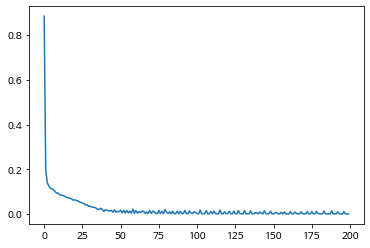

In [44]:
plt.plot(range(train_epochs),loss_list)

In [45]:
scaler = dataset.scaler
df_test = data_train.copy()
df_test["value"] = scaler.transform(df_test["value"])
df_test["date"] = pd.to_datetime(df_test["date"].values)

delta = df_test["date"][1] - df_test["date"][0]
for i in range(pred_len):
    df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True)
df_test = df_test.fillna(0)


df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()
df_test_y = df_test.iloc[-label_len-pred_len:].copy()

df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
test_time_x = time_features(df_test_x, freq=dataset.freq) #인풋 타임 스템프
test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


test_time_y = time_features(df_test_y, freq=dataset.freq) #아웃풋 타임스템프
test_data_y =df_test_numpy[-label_len-pred_len:] #아웃풋 데이터
test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.



test_time_x = test_time_x
test_time_y = test_time_y
test_data_y = test_data_y.astype(np.float64)
test_data_x = test_data_x.astype(np.float64)

_test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
_test_loader = DataLoader(_test,batch_size=1,shuffle=False)

preds = []


for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):

    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
    preds = outputs.detach().cpu().numpy()

preds = scaler.inverse_transform(preds[0])

df_test.iloc[-pred_len:, 1:] = preds

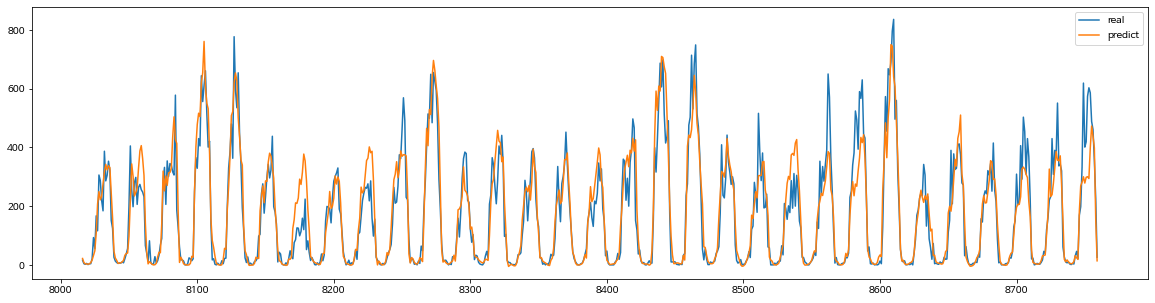

In [47]:
import matplotlib.pyplot as plt

real = data["value"].to_numpy()
result = df_test["value"].iloc[-744:].to_numpy()

real = min_max_scaler.inverse_transform(real.reshape(-1,1)).reshape(-1)
result = min_max_scaler.inverse_transform(result.reshape(-1,1)).reshape(-1)

plt.figure(figsize=(20,5))
plt.plot(range(8016,8760),real[8016:], label="real")
plt.plot(range(8760-744,8760),result, label="predict")
plt.legend()
plt.show()